# Membrane potentials

In [4]:
"""Further command line arguments:
        c       script will close all open plots
        sli     data of the original simulation written in sli will be analyzed. 
                Note that at this point, the data must be of the same simulation type, 
                as specifications are loaded from .npy-files of the pynest simulation. 

    Overview over all populations: Raster plot, mean rates, mean CV of ISI per population.
"""
from imp import reload
import numpy as np
import h5py
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import rcParams
import sys, os
import time
sys.path.append(os.path.abspath('../presentation')) # include path with style
sys.path.append(os.path.abspath('../transition/')) # include path with simulation specifications
import pres_style as style; reload(style)
# Close other plots by adding 'c' after 'run <script>' 
if 'c' in sys.argv:
    plt.close('all')
picture_format = '.pdf'
figure_path = "./figures"
######################################################
# Import specific moduls
import network_params_trans; reload(network_params_trans)
import user_params_trans as user; reload(user)
%matplotlib inline

show_fig = False
save_fig = True
xfactor = 2.6
style.rcParams['figure.figsize'] = (xfactor*6.2, xfactor*3.83) 
figure_path = os.path.join(".", "figures")

reverse_order = True # do analysis such that plots resemble those of the paper (starting with L6i)
plotting = True


In [7]:
# DATA
data_path = user.data_dir
sim_spec = "a1.0_t1.2_00"
# Original data
file_name  = sim_spec + ".hdf5"  

In [8]:
# Visualize data file

def pn(n):
    print(n)
    
data_file = h5py.File(os.path.join(data_path, file_name), "r")
data_file.visit(pn)
data_file.close()

d1.00_j2.00_sdJ0.10
d1.00_j2.00_sdJ0.10/spikes
d1.00_j2.00_sdJ0.10/spikes/L23e
d1.00_j2.00_sdJ0.10/spikes/L23e/rec_neuron_i
d1.00_j2.00_sdJ0.10/spikes/L23e/times
d1.00_j2.00_sdJ0.10/spikes/L23i
d1.00_j2.00_sdJ0.10/spikes/L23i/rec_neuron_i
d1.00_j2.00_sdJ0.10/spikes/L23i/times
d1.00_j2.00_sdJ0.10/spikes/L4e
d1.00_j2.00_sdJ0.10/spikes/L4e/rec_neuron_i
d1.00_j2.00_sdJ0.10/spikes/L4e/times
d1.00_j2.00_sdJ0.10/spikes/L4i
d1.00_j2.00_sdJ0.10/spikes/L4i/rec_neuron_i
d1.00_j2.00_sdJ0.10/spikes/L4i/times
d1.00_j2.00_sdJ0.10/spikes/L5e
d1.00_j2.00_sdJ0.10/spikes/L5e/rec_neuron_i
d1.00_j2.00_sdJ0.10/spikes/L5e/times
d1.00_j2.00_sdJ0.10/spikes/L5i
d1.00_j2.00_sdJ0.10/spikes/L5i/rec_neuron_i
d1.00_j2.00_sdJ0.10/spikes/L5i/times
d1.00_j2.00_sdJ0.10/spikes/L6e
d1.00_j2.00_sdJ0.10/spikes/L6e/rec_neuron_i
d1.00_j2.00_sdJ0.10/spikes/L6e/times
d1.00_j2.00_sdJ0.10/spikes/L6i
d1.00_j2.00_sdJ0.10/spikes/L6i/rec_neuron_i
d1.00_j2.00_sdJ0.10/spikes/L6i/times
d1.00_j2.00_sdJ0.10/voltage
d1.00_j2.00_sdJ0.10/vol

## Basic data

In [9]:
# DATA
data_path = user.data_dir
sim_spec = "a1.0_t1.2_00"
# Original data
file_name  = sim_spec + ".hdf5"  

# Open file: data
data_file = h5py.File(os.path.join(data_path, file_name), "r")

# Simulation attributes
area    = data_file.attrs["area"]   
t_sim   = data_file.attrs["t_sim"]  
t_trans = data_file.attrs["t_trans"]
dt      = data_file.attrs["dt"]    
populations   = data_file.attrs["populations"].astype("|U4")
layers        = data_file.attrs["layers"].astype("|U4")        
types         = data_file.attrs["types"].astype("|U4")     
n_populations = data_file.attrs["n_populations"]
n_layers      = data_file.attrs["n_layers"]       
n_types       = data_file.attrs["n_types"] 

t_measure = t_sim - t_trans

dists = data_file.attrs["dists"][:]

# labels & colors: need to be adapted if n_types != (e, i)
layer_colors = style.colors[:n_layers]
colors = np.array([color for color in layer_colors for i in range(n_types)])
colors[1::2] = colors[1::2] * 0.4   #### adapt for more than two types!
if reverse_order:
    populations = populations[::-1]
    layers = layers[::-1]
    types = types[::-1]
    colors = colors[::-1]
data_file.close()

## Prepare the data

In [10]:
"""Analysis of membrane potential distribution."""
# Open file: data
data_file = h5py.File(os.path.join(data_path, file_name), "r")

n_bins_Vs   = 200
V_min = -100
V_max = -50
V_step = (V_max - V_min) / n_bins_Vs
bin_edges = np.linspace(V_min, V_max, n_bins_Vs + 1)
n_hist_max  = 10 # maximum number of single histogram to be shown

print("Prepare data")
for sim_spec2 in data_file.keys():  
    print(sim_spec2)
    volt_grp = data_file[sim_spec2 + "/voltage"]
    
    # Times
    dt_volt = volt_grp.attrs["dt_volt"]
    t_min_volt  = volt_grp.attrs["t_min"]
    t_max_volt  = volt_grp.attrs["t_max"]
    times_volt  = np.arange(t_min_volt + dt_volt, t_max_volt, dt_volt) *1e-3 # s
    
    histo_means     = np.zeros((n_populations, n_bins_Vs))
    Vs_plot         = np.zeros((n_populations, n_hist_max, len(times_volt)))    
    for i, population in enumerate(populations):
        print(population)
        # Get membrane potentials
        volts_all = volt_grp[population][:]
        histo_means[i], b_e  = np.histogram(volts_all, bin_edges, normed=True)
        
        n_hist = min(n_hist_max, len(volts_all))
        Vs_plot[i][:n_hist] = volts_all[:n_hist]

data_file.close()

Prepare data
d1.00_j2.00_sdJ0.10
L6i
L6e
L5i
L5e
L4i
L4e
L23i
L23e


save figure to membrane_potential_a1.0_t1.2_00_L23e.pdf


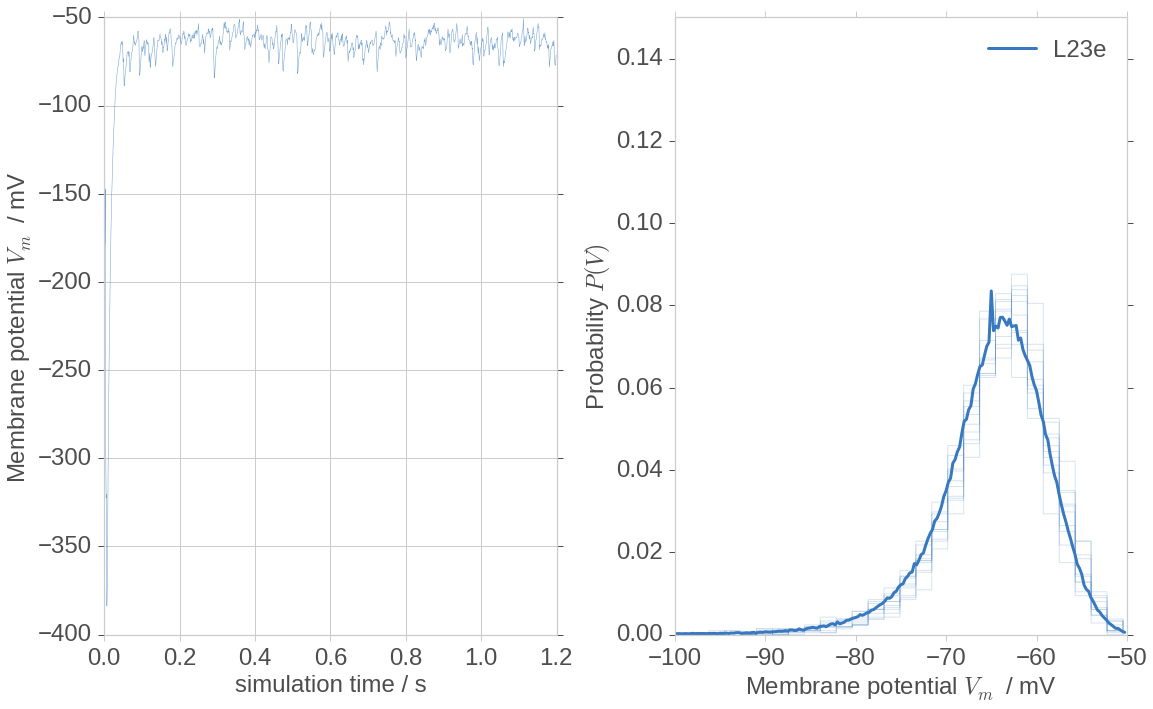

In [12]:
fig = plt.figure()
if not save_fig:
    suptitle = 'Simulation for: area = %.1f, time = %ims'%(area, t_sim)
    suptitle += '\nfile: ' + sim_spec
    if sli: 
        suptitle += '  SLI'
    fig.suptitle(suptitle, y=0.98)
# Membrane pot over time
ax0 = plt.subplot2grid((1, 2), (0, 0), colspan=1, rowspan=1)
# Histogram of membrane pot
ax1 = plt.subplot2grid((1, 2), (0, 1), colspan=1, rowspan=1)

for i, population in enumerate(populations):
    if i==7:
    #if True:
        j = 0
        volts_single = Vs_plot[i][j]
        ax0.plot(times_volt, volts_single, 
            '-', color=colors[i], alpha=0.7, linewidth=0.5, label=population)
        ax1.plot(bin_edges[:-1], histo_means[i], linewidth=3., color=colors[i], label=population)
        ax1.hist(Vs_plot[i].T, bins=n_bins_Vs, normed=True, histtype='step', 
            fill=False, linewidth=1.0, color=[colors[i]]*n_hist_max, alpha=0.2)
    
# Potential over time
xlim = np.array([t_min_volt, t_max_volt]) *1e-3 # s
ax0.set_xlabel('simulation time / s')
ax0.set_ylabel('Membrane potential $V_m$ / mV')
ax0.set_xlim(*xlim)
ax0.grid(True)

# Histogram
ax1.set_ylabel('Probability $P(V)$')
ax1.set_xlabel('Membrane potential $V_m$ / mV')
ax1.set_xlim(V_min, V_max)
ax1.set_ylim(0, 0.15)
ax1.grid(False)
ax1.legend(loc=0)
    
for ax in fig.axes:
    style.fixticks(ax)
fig_name = "membrane_potential_" + sim_spec

fig_name += "_L23e"
fig_name += picture_format

if save_fig:
    print("save figure to " + fig_name)
    fig.savefig(os.path.join(figure_path,fig_name))

if show_fig:
    fig.show()

d1.00_j2.00_sdJ0.10
Popul.	rate  	reduced fit	full fit        	Brunel's for v0
      	[  v0]	[ mu0  sd0]	[  v1  mu1  sd1]	[ mu_b  sd_b]
L6i	[7.98]	[8.12 4.82]	[8.35 8.13 4.87]	[43.53 5.68]
L6e	[0.97]	[2.44 5.85]	[1.83 2.53 6.31]	[47.26 4.64]
L5i	[8.63]	[7.83 5.12]	[8.06 7.82 5.03]	[5.84 5.50]
L5e	[8.18]	[6.40 5.99]	[6.44 6.33 5.68]	[24.91 6.24]
L4i	[5.81]	[5.95 5.78]	[6.24 5.97 5.86]	[53.04 4.54]
L4e	[4.43]	[5.96 5.45]	[6.21 6.03 5.82]	[35.06 3.80]
L23i	[3.18]	[6.04 5.03]	[4.44 6.10 5.33]	[40.37 3.64]
L23e	[0.97]	[1.05 6.53]	[2.25 1.16 7.27]	[38.17 2.83]


/usr/local/lib/python3.4/dist-packages/scipy/integrate/quadpack.py:352: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


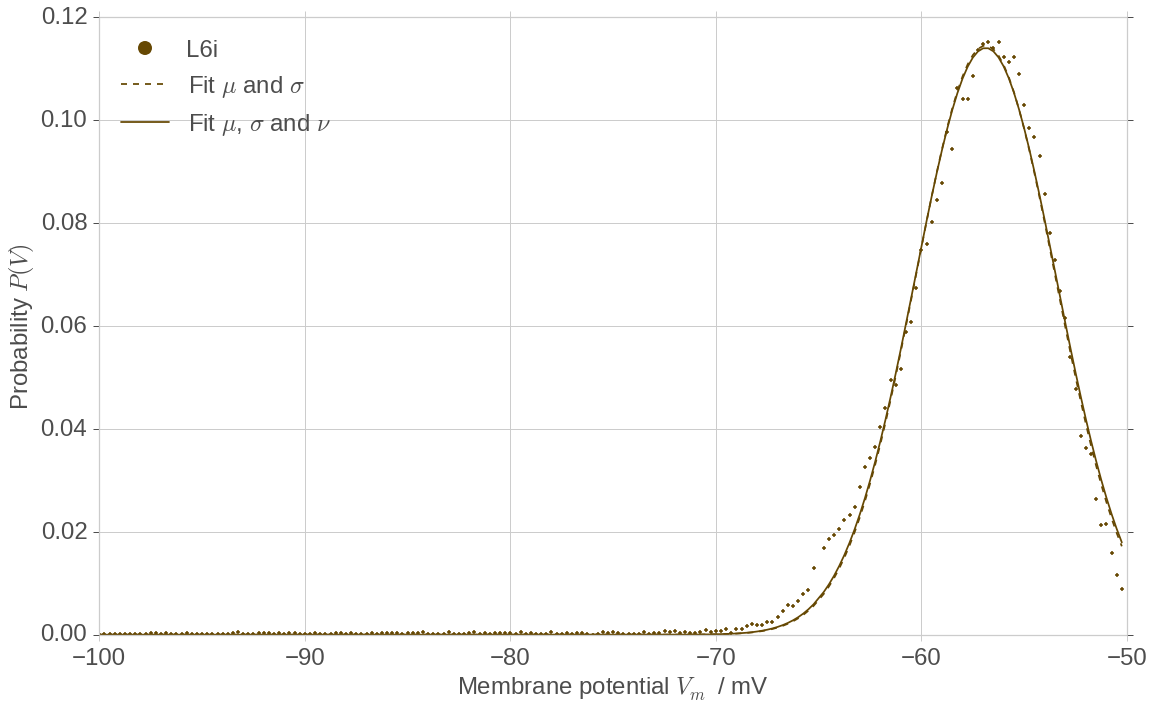

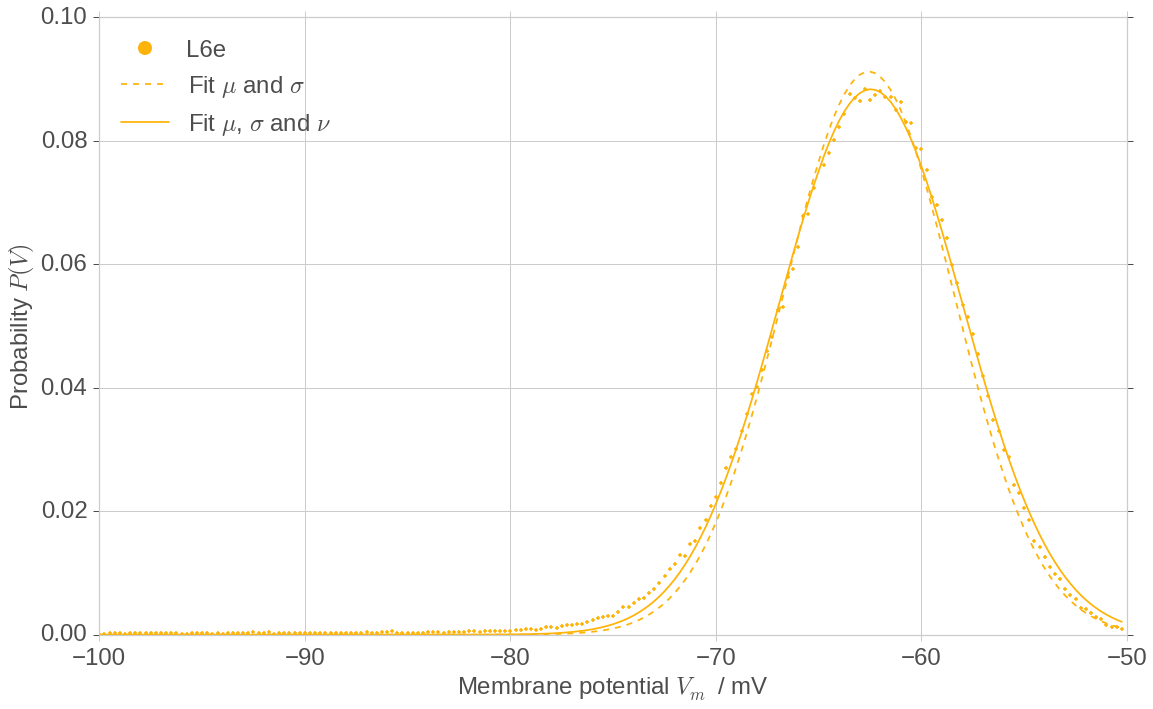

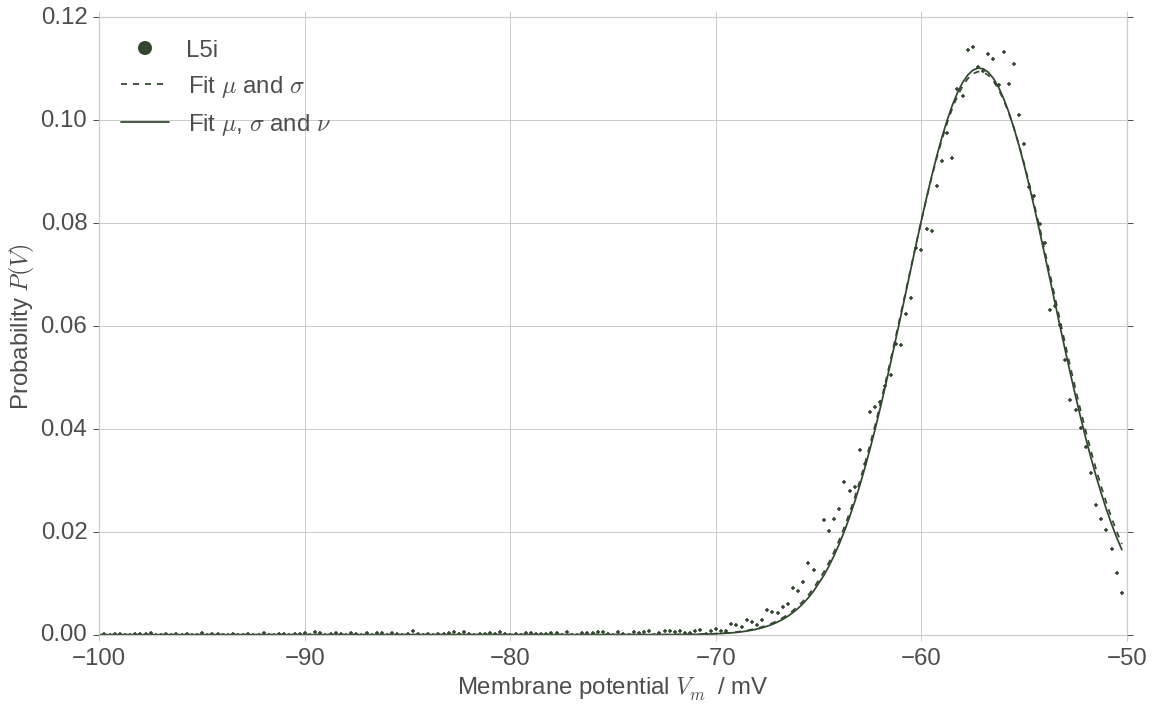

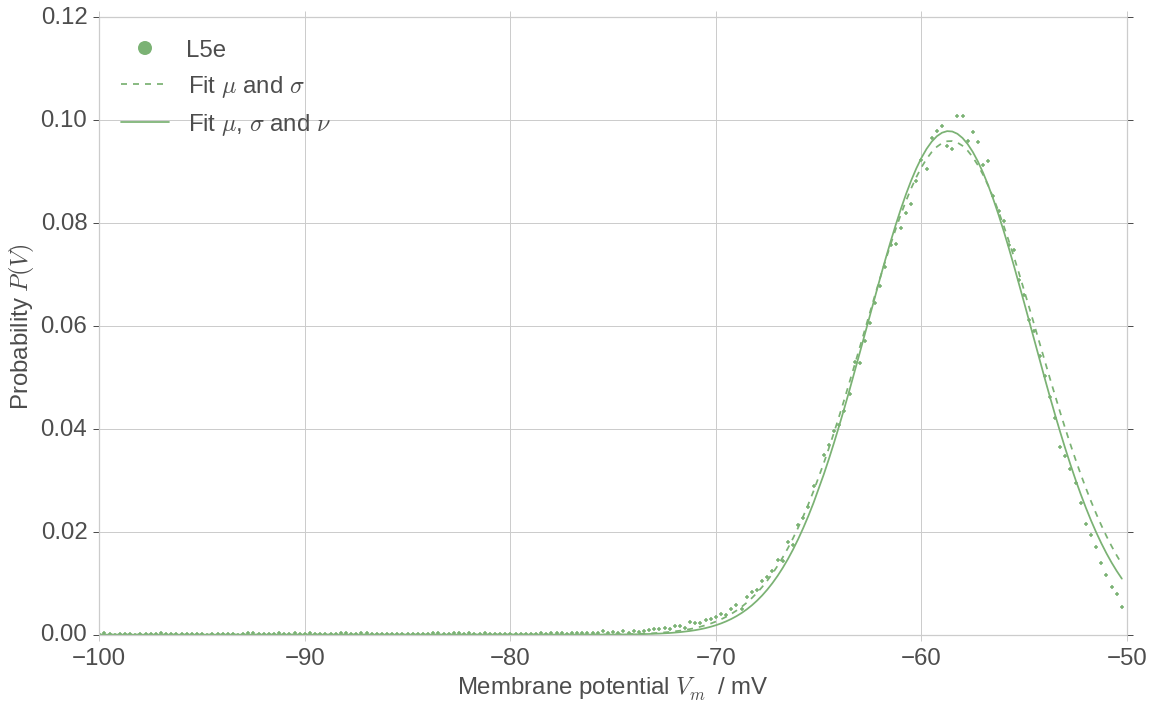

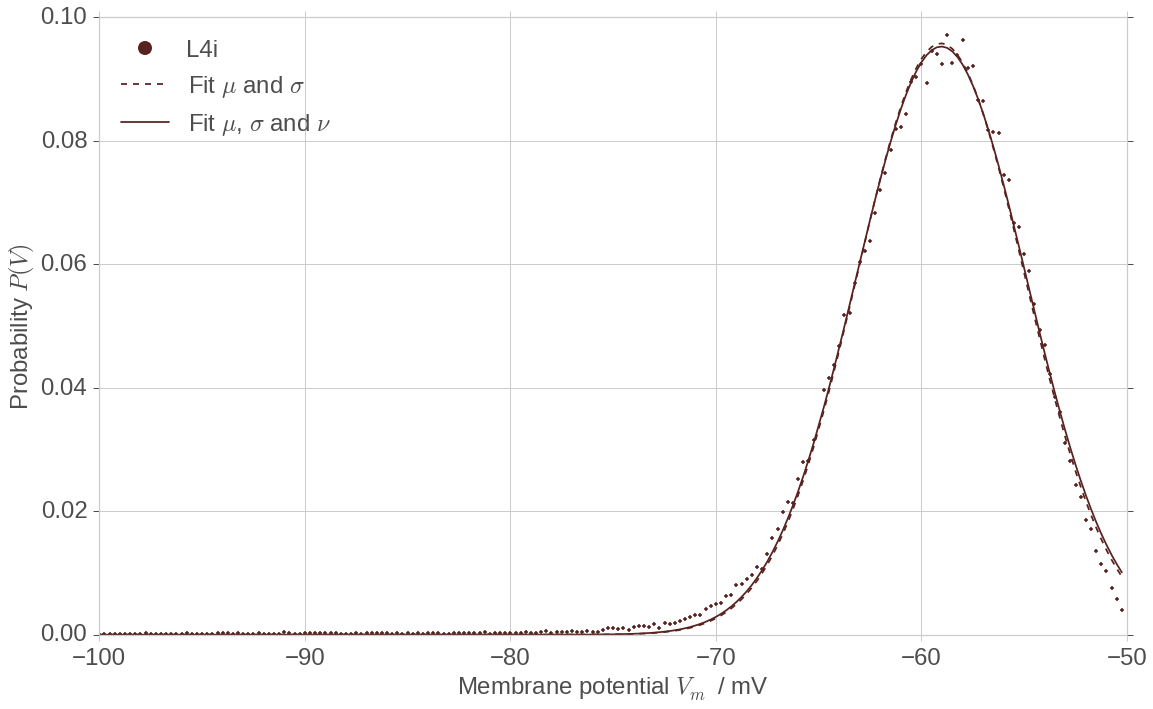

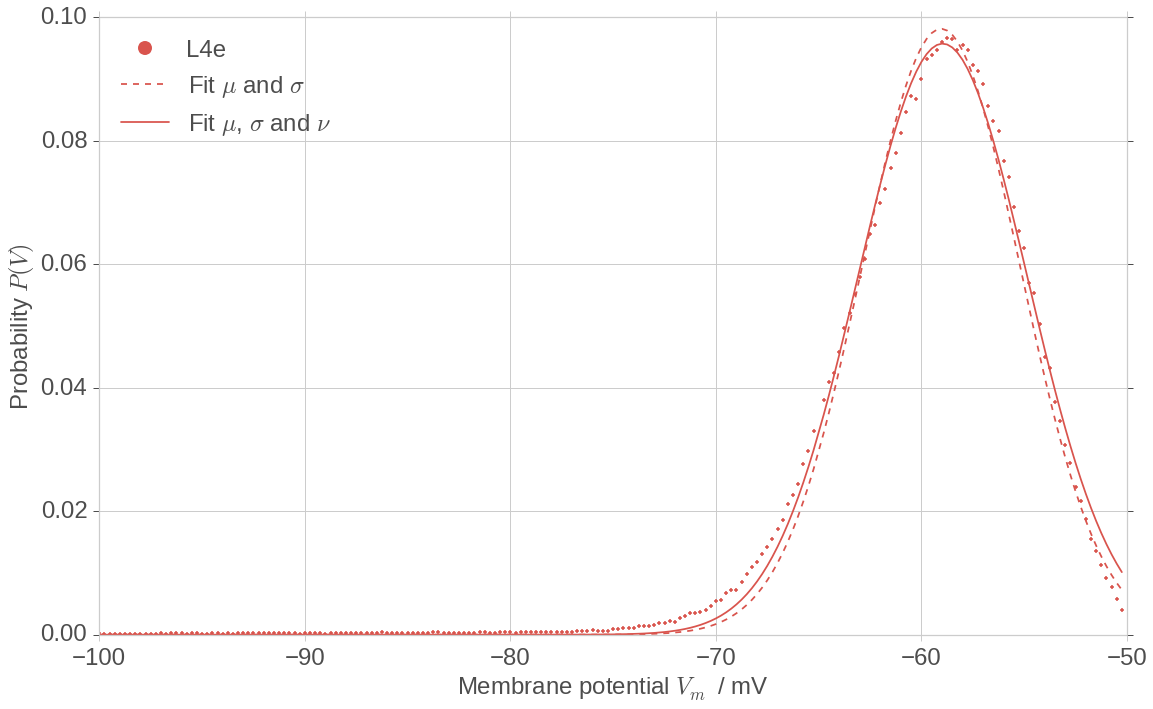

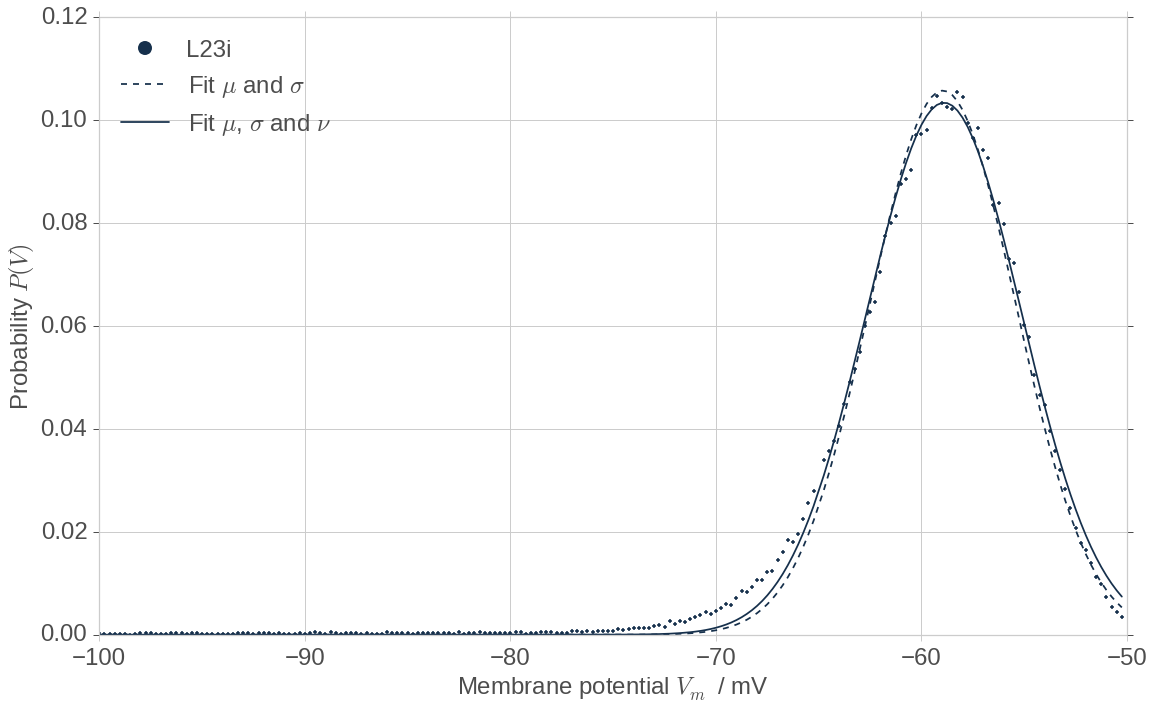

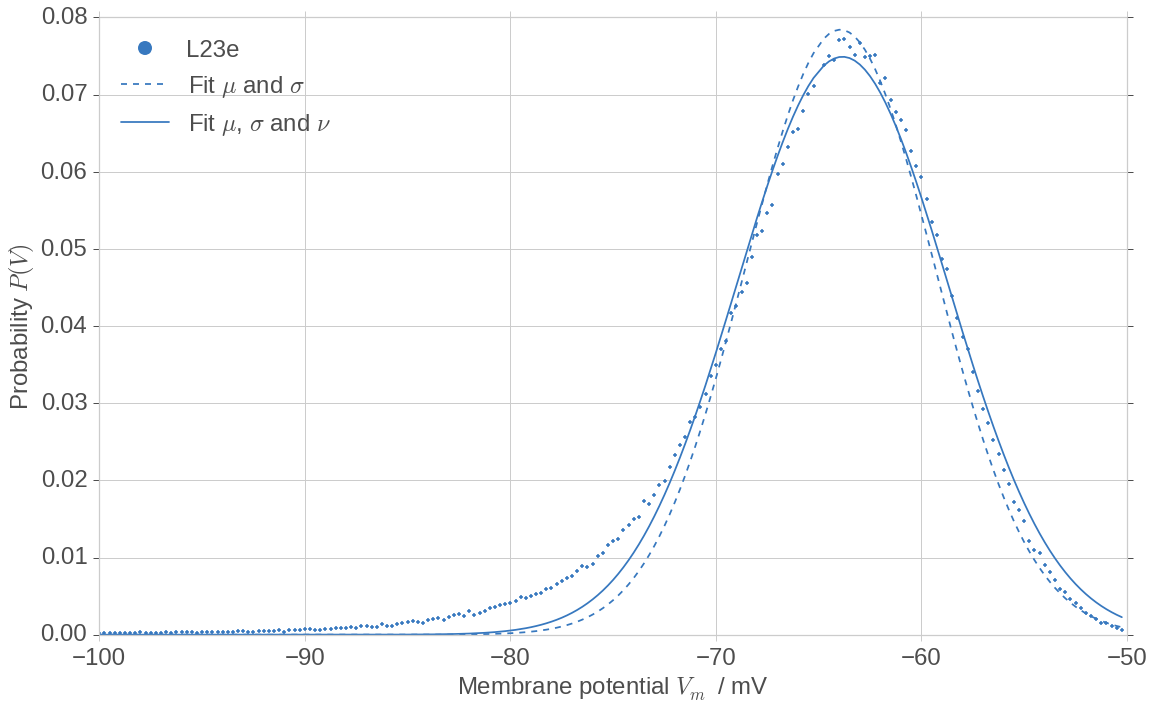

In [13]:
from scipy.optimize import curve_fit

# Open file: results
res_file_name = sim_spec + "_res.hdf5"
res_file = h5py.File(os.path.join(data_path, res_file_name), "r")
sim_spec2 = "d1.00_j2.00_sdJ0.10"
print(sim_spec2)
res_grp = res_file[sim_spec2]
    
rates_mean   = res_grp["rates_mean"][:]
rates_std    = res_grp["rates_std"][:]
cv_isi_mean  = res_grp["cv_isi_mean"][:]
cv_isi_std   = res_grp["cv_isi_std"][:]
synchrony    = res_grp["synchrony"][:]

res_file.close()


# Model
area            = 1.0
connection_type = "fixed_indegree"
g               = 4.0
rate_ext        = 8.0 # Hz background rate
PSC_rel_sd      = 0.1
delay_rel_sd    = 0.5

j02             = 2.0
n_neurons       = "micro"
C_ab            = "micro"
model           = network_params_trans.net(area=area, 
                                           n_neurons=n_neurons, C_ab=C_ab, 
                                           connection_type=connection_type,
                                           j02=j02, g=g, rate_ext=rate_ext,
                                           PSC_rel_sd=PSC_rel_sd, 
                                           delay_rel_sd=delay_rel_sd) 

# Input according to Brunel
mu_brunel = model.mu(rates_mean)
sd_brunel = model.sd(rates_mean)

V_array_full = bin_edges[:-1]
V_r_arg = np.argmin(np.abs(V_array_full - (model.V_r + model.E_L)))
V_array = np.delete(V_array_full, V_r_arg)

print("Popul.\trate  \treduced fit\tfull fit        \tBrunel's for v0")
print("      \t[  v0]\t[ mu0  sd0]\t[  v1  mu1  sd1]\t[ mu_b  sd_b]")
for i, population in enumerate(populations):
    P_V_data = np.delete(histo_means[i], V_r_arg) # Remove outlier due to V_r

    # Initial guess
    mu0 = 1 # V
    sd0 = 9 # V
    V_guess = model.prob_V(V_array, mu0, sd0, v=rates_mean[i])

    # Fit only mu and sd
    func = lambda V, mu, sd: model.prob_V(V, mu, sd, v=rates_mean[i])
    p0 = (1, 9)
    popt, pcov = curve_fit(func, V_array, P_V_data, p0=p0)
    V_opt = func(V_array, *popt)

    # Fit v, mu, sd
    func_v = lambda V, mu, sd, v: model.prob_V(V, mu, sd, v)
    p0 = (mu0, sd0, rates_mean[i])
    popt_v, pcov_v = curve_fit(func_v, V_array, P_V_data, p0=p0)
    V_opt_v = func_v(V_array, *popt_v)
    
    # Theoretical distirbution using Brunel's mu and sd but measured rate v0
    V_theo = model.prob_V(V_array, mu_brunel[i], sd_brunel[i], rates_mean[i])

    # Plotting
    fig = plt.figure()
    ax1 = plt.subplot2grid((1, 1), (0, 0), colspan=1, rowspan=1)

    ax1.plot(V_array, P_V_data, ".", color=colors[i], label=population)
    #ax1.plot(V_array, V_guess, color=colors[i], label=population)
    ax1.plot(V_array, V_opt, "--", color=colors[i], label="Fit $\mu$ and $\sigma$")
    ax1.plot(V_array, V_opt_v, "-", color=colors[i], label="Fit $\mu$, $\sigma$ and $\\nu$")
    #ax1.plot(V_array, V_theo, "-.", color=colors[i], label=population)

    ax1.set_ylabel('Probability $P(V)$')
    ax1.set_xlabel('Membrane potential $V_m$ / mV')
    ax1.set_xlim(V_min, V_max)
    ax1.grid(True)
    ax1.legend(loc='best')
    for ax in fig.axes:
        style.fixticks(ax)
    
    # Printing
    results_str = "[%.2f]\t[%.2f %.2f]\t[%.2f %.2f %.2f]\t[%.2f %.2f]"%(rates_mean[i], 
                                                                popt[0], popt[1], 
                                                                popt_v[2], popt_v[0], popt_v[1], 
                                                                mu_brunel[i], sd_brunel[i])
    print(population + "\t" + results_str)
    
    fig_name = "membrane_potential_fit_" + population
    #fig.savefig(os.path.join(figure_path,fig_name + picture_format))
